# Capstone Project
## Student Performance Classifier

### Goal

This machine learning project is to classify students into different grade classes. While doing so, we will also determine which features truly matter regarding good grades and bad grades. 

### Installing kagglehub to download data from Kaggle

In [ ]:
pip install kagglehub

### Necessary libraries for the entire code

In [84]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import tree, ensemble
import graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import plot_tree, export_graphviz, DecisionTreeClassifier
import psutil
import time
from sklearn.model_selection import cross_val_score
import random
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

## Random seed

Setting a random seed to make my thought process easier to follow

In [4]:
# Set a global random seed
seed = 42
np.random.seed(seed)
random.seed(seed)

### Downloading dataset

The dataset has been downloaded from Kaggle and is saved into file_path. The code used to load the dataset is provided by Kaggle.

In [7]:

# Set the path to the file you'd like to load
file_path = "Student_performance_data _.csv"

# Load the latest version of the dataset
# This code is provided by Kaggle
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "rabieelkharoua/students-performance-dataset",
  file_path,
)

print("First 5 records:", df.head())
#Visualizing how many classes we have. The GradeClass column will be our Y variable. 
print("Number of classes:", df['GradeClass'].nunique())
print("Class labels:", df['GradeClass'].unique())


/var/folders/t6/zybm3nvx39s8_lhk77zthmj40000gn/T/ipykernel_60967/580767423.py:6: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:    StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0       1001   17       1          0                  2        19.833723   
1       1002   18       0          0                  1        15.408756   
2       1003   15       0          2                  3         4.210570   
3       1004   17       1          0                  3        10.028829   
4       1005   17       1          0                  2         4.672495   

   Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
0         7         1                2                0       0      1   
1         0         0                1                0       0      0   
2        26         0                2                0       0      0   
3        14         0                3                1       0      0   
4        17         1                3                0       0      0   

   Volunteering       GPA  GradeClass  
0             0  2.929196         2.0  
1

## Visualising how much data I have for each class

In [10]:
class_counts = df['GradeClass'].value_counts()

print(class_counts)

GradeClass
4.0    1211
3.0     414
2.0     391
1.0     269
0.0     107
Name: count, dtype: int64


## Adding more data 
Given that my initial dataset is composed of only 2392 rows I would like to add more to reach more than 10000 and make better predictions. Also, given that my data so far was mostly focused on class 4 I focused on the other classes. 

In [13]:
# Number of new samples per class you want to add (you can adjust these)
samples_to_add = {
    0: 2000,  # add 500 samples to class 0
    1: 2000,  # add 500 samples to class 1
    2: 2000,  # add 500 samples to class 2
    3: 1500,  # add 500 samples to class 3
    4: 500,  # add 500 samples to class 3
}

new_rows = []

for class_label, n_samples in samples_to_add.items():
    # Filter rows of this class only
    class_rows = df[df['GradeClass'] == class_label]

    for _ in range(n_samples):
        # Sample a random row from the class
        row = class_rows.sample(1).iloc[0].copy()

        # Add noise to numeric columns
        for col in ['math score', 'reading score', 'writing score']:
            if col in df.columns:
                noise = np.random.normal(0, 5)  # mean=0, std=5
                new_val = row[col] + noise
                # Clamp values to valid range 0-100
                row[col] = max(0, min(100, new_val))

        # Append synthetic row
        new_rows.append(row)

# Create DataFrame from synthetic rows
synthetic_df = pd.DataFrame(new_rows)

# Concatenate original and synthetic data
augmented_df = pd.concat([df, synthetic_df], ignore_index=True)

print(f"Original dataset size: {len(df)}")
print(f"Synthetic samples added: {len(synthetic_df)}")
print(f"Augmented dataset size: {len(augmented_df)}")
class_counts = augmented_df['GradeClass'].value_counts()

print(class_counts)

Original dataset size: 2392
Synthetic samples added: 8000
Augmented dataset size: 10392
GradeClass
2.0    2391
1.0    2269
0.0    2107
3.0    1914
4.0    1711
Name: count, dtype: int64


### Checking for missing values, NaN, Na values in the dataset

I am not getting rid of zeros since those are important. For example, if a student had 0 extracurricular classes. 

In [16]:
null = pd.isnull(augmented_df) #using isnull from pandas to fin NaN and NA
print(null)
pd.isnull(augmented_df).sum().sum() #showing the sum of the missing values

       StudentID    Age  Gender  Ethnicity  ParentalEducation  \
0          False  False   False      False              False   
1          False  False   False      False              False   
2          False  False   False      False              False   
3          False  False   False      False              False   
4          False  False   False      False              False   
...          ...    ...     ...        ...                ...   
10387      False  False   False      False              False   
10388      False  False   False      False              False   
10389      False  False   False      False              False   
10390      False  False   False      False              False   
10391      False  False   False      False              False   

       StudyTimeWeekly  Absences  Tutoring  ParentalSupport  Extracurricular  \
0                False     False     False            False            False   
1                False     False     False            False

0

### Feature pre-selection

Given that there are no missing values and the dataset is clean, we can move on to selecting which columns to keep. This initial selection is to remove unwanted bias and to check if the coefficient of certain features is too high, thus they are too similar to each other. 

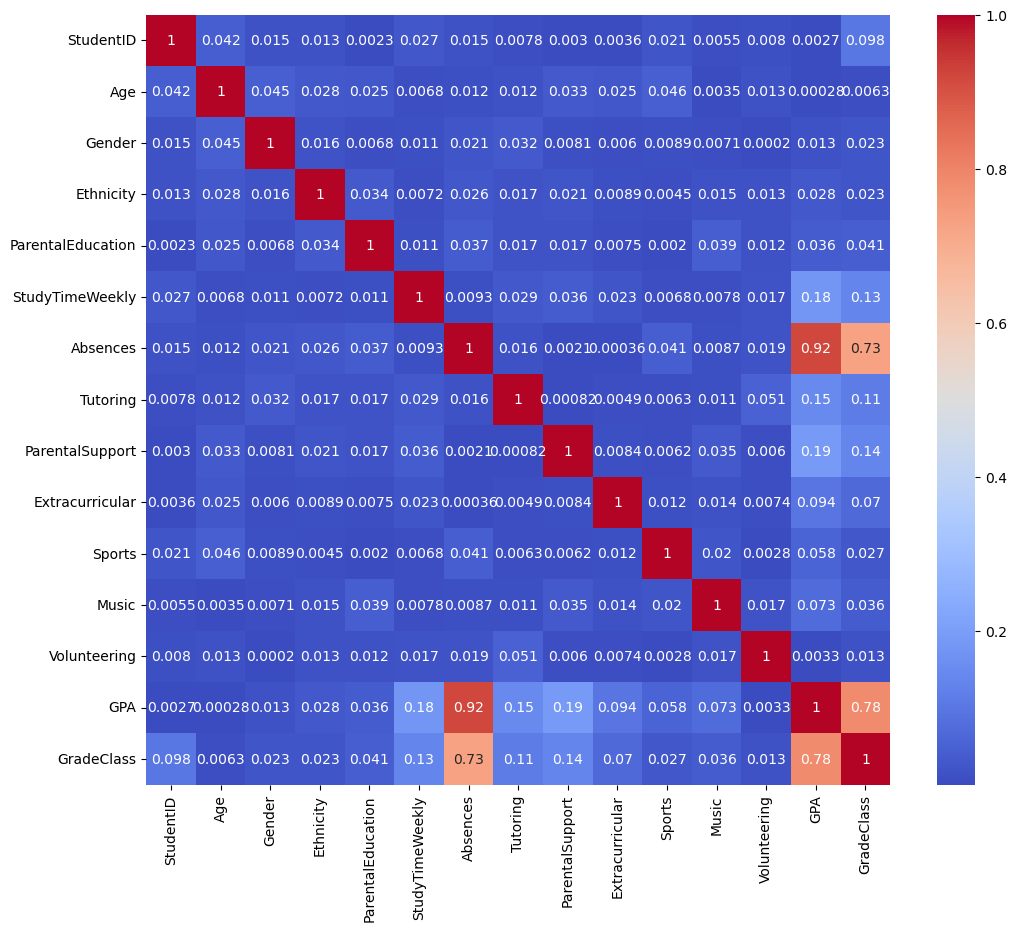

In [19]:
#Separating target column
X = augmented_df.drop(columns=['GradeClass'])
y = augmented_df['GradeClass']

#Checking feature correlation without droping the target column
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr().abs()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [21]:
#Checking for feature impact

model = LinearRegression().fit(X, y)
coeffs = pd.Series(model.coef_, index=X.columns)
print("Regression Coefficients:\n", coeffs.sort_values())

Regression Coefficients:
 GPA                 -1.320661
ParentalSupport     -0.034232
Age                 -0.029525
Tutoring            -0.025866
Absences            -0.025401
StudentID           -0.000469
Ethnicity            0.001742
StudyTimeWeekly      0.002045
Extracurricular      0.005314
ParentalEducation    0.015603
Volunteering         0.086727
Sports               0.106380
Gender               0.132873
Music                0.133620
dtype: float64


### Dropping features
The GPA feature has to be dropped since it technically represents the same as our target 'GradeClass'. They are both measures of a student's academic performance and are targets in their own right.
If we already have the GPA, we can calculate the Class Grade directly without the need for machine learning.


In [24]:
#Dropping GPA to reanalyse the feature impact and make more sense of the other columns without the GPA impact
X2 = augmented_df.drop(columns=['GPA', 'GradeClass'])  # Drop GPA and actual target

model = LinearRegression().fit(X2, y)
coeffs = pd.Series(model.coef_, index=X2.columns)
print("Regression Coefficients:\n", coeffs.sort_values()) 

Regression Coefficients:
 Tutoring            -0.349546
Extracurricular     -0.239224
ParentalSupport     -0.222704
Sports              -0.158186
Music               -0.068976
StudyTimeWeekly     -0.035211
Age                 -0.018919
Ethnicity           -0.009825
StudentID           -0.000475
ParentalEducation    0.010459
Volunteering         0.078728
Gender               0.104169
Absences             0.108068
dtype: float64


As can be seen, dropping GPA highly increased the feature impact of other columns.
So we are dropping the following features: 

1. GPA: multicollinearity with the target column.
2. StudentID: it's just an informational value, does not impact grades.
3. Ethnicity: could lead to racial bias
4. Age: no correlation with other features and very low impact. 

In [27]:
#Dropping all columns that will not be of use

final_X = augmented_df.drop(columns=['GPA', 'GradeClass', 'Ethnicity', 'StudentID', 'Age'])
print(final_X)

       Gender  ParentalEducation  StudyTimeWeekly  Absences  Tutoring  \
0         1.0                2.0        19.833723       7.0       1.0   
1         0.0                1.0        15.408756       0.0       0.0   
2         0.0                3.0         4.210570      26.0       0.0   
3         1.0                3.0        10.028829      14.0       0.0   
4         1.0                2.0         4.672495      17.0       1.0   
...       ...                ...              ...       ...       ...   
10387     1.0                2.0         2.247659      13.0       1.0   
10388     1.0                2.0         5.508934      24.0       0.0   
10389     1.0                1.0         9.962593      28.0       1.0   
10390     1.0                2.0         1.040917      18.0       1.0   
10391     1.0                0.0         6.441612      26.0       0.0   

       ParentalSupport  Extracurricular  Sports  Music  Volunteering  
0                  2.0              0.0     0.0    1

## Splitting data
The data will be split 60% into training, 20% into testing and 20% into validation.

In [30]:
#Splitting X
# Step 1: Splitting off 60% training data
X_train, temp_X = train_test_split(final_X, test_size=0.60, random_state=42)

# Step 2: Splitting the remaining 40% into 20% validation and 20% test
X_val, X_test = train_test_split(temp_X, test_size=0.50, random_state=42)


#Splitting Y
# Step 1: Splitting off 60% training data
Y_train, temp_Y = train_test_split(y, test_size=0.60, random_state=42)

# Step 2: Splitting the remaining 40% into 20% validation and 20% test
Y_val, Y_test = train_test_split(temp_Y, test_size=0.50, random_state=42)

## Checking for 0
Given that I care about the 0 and don't want to get rid of them I am seeing how many I have and converting them to string value to have them be part of the training.

In [33]:
#checking for 0
for col in X_train.columns:
    zero_count = (X_train[col] == 0).sum()
    total_count = X_train.shape[0]
    print(f"Feature '{col}': zeros = {zero_count} ({zero_count/total_count:.2%})")

Feature 'Gender': zeros = 2049 (49.30%)
Feature 'ParentalEducation': zeros = 419 (10.08%)
Feature 'StudyTimeWeekly': zeros = 0 (0.00%)
Feature 'Absences': zeros = 346 (8.33%)
Feature 'Tutoring': zeros = 2717 (65.38%)
Feature 'ParentalSupport': zeros = 264 (6.35%)
Feature 'Extracurricular': zeros = 2488 (59.87%)
Feature 'Sports': zeros = 2883 (69.37%)
Feature 'Music': zeros = 3298 (79.36%)
Feature 'Volunteering': zeros = 3520 (84.70%)


In [35]:
# Categorical columns:
categorical_cols = ['Gender', 'Absences', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering']

# OrdinalEncoder the categorical features
encoder = OrdinalEncoder()
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_val_cat = encoder.transform(X_val[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])


### Scaling and standarizing 

Even though not all models require this, I want to scale to be sure that this is not affecting my final results. Y is not scaled since it is not necessary; it is not included in the training so it would not affect the model. Final variables to use are: 

1. X_train_processed - Y_train
2. X_val_processed - Y_val
3. X_test_processed - Y_test

In [38]:
numeric_cols = ['StudyTimeWeekly']
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_val_num = scaler.transform(X_val[numeric_cols])
X_test_num = scaler.transform(X_test[numeric_cols])

In [42]:

X_train_processed = np.hstack([X_train_num, X_train_cat])
X_val_processed = np.hstack([X_val_num, X_val_cat])
X_test_processed = np.hstack([X_test_num, X_test_cat])

print("Number of features in training set:", X_train_processed.shape[1])
print("Number of features in validation set:", X_val_processed.shape[1])
print("Number of features in test set:", X_test_processed.shape[1])


Number of features in training set: 10
Number of features in validation set: 10
Number of features in test set: 10


## Models 

We will be training the data on 3 models: 

1. Decision Trees
2. Random forest
3. KNN

For this part, I will not be tuning any hyperparameters. I will be making basic choices as to how much depth my tree will need, but no more. Once I have selected my final model, I will work on its hyperparameter tuning. 

### Decision Tree

Only tuning done at this stage is the best depth to be able to analyse if with the best depth we get as good as a result as with the other models that will be trained. 

In [44]:
bestdepth=-1 #initial depth value
bestscore=0
max_depth = 15 #initial value

#code to decide what depth value gives the score while keeping a balance between training and validation score
for i in range(15):
    clf = tree.DecisionTreeClassifier(max_depth=i+1)
    #fit the training sets
    clf.fit(X_train_processed, Y_train)
    #update trainscore
    trainscore= clf.score(X_train_processed, Y_train)
    #update valscore
    valscore= clf.score(X_val_processed, Y_val)
    print( 'Depth:', i+1, 'Train Score:', trainscore, 'Validation Score:', valscore)
    if  valscore > bestscore:
        #update bestscore
        bestscore= valscore
        #update depth
        bestdepth= i + 1
print(bestdepth)

Depth: 1 Train Score: 0.34600577478344563 Validation Score: 0.3559974342527261
Depth: 2 Train Score: 0.4764196342637151 Validation Score: 0.4894162924951892
Depth: 3 Train Score: 0.5262271414821944 Validation Score: 0.5259781911481719
Depth: 4 Train Score: 0.5570259865255053 Validation Score: 0.5509942270686338
Depth: 5 Train Score: 0.5957651588065448 Validation Score: 0.5753688261706222
Depth: 6 Train Score: 0.6417228103946102 Validation Score: 0.6318152661962797
Depth: 7 Train Score: 0.6970644850818094 Validation Score: 0.6590763309813983
Depth: 8 Train Score: 0.7644369586140519 Validation Score: 0.7129570237331623
Depth: 9 Train Score: 0.8298845043310876 Validation Score: 0.7777421423989737
Depth: 10 Train Score: 0.8835418671799807 Validation Score: 0.8255291853752406
Depth: 11 Train Score: 0.9294995187680462 Validation Score: 0.8675432969852469
Depth: 12 Train Score: 0.9578922040423484 Validation Score: 0.891276459268762
Depth: 13 Train Score: 0.9756977863330125 Validation Score: 0

In [46]:
clf = tree.DecisionTreeClassifier(max_depth = 15)
Y_train = Y_train.astype(int)
Y_val = Y_val.astype(int)
#Fit X_train and y_train 
clf.fit(X_train_processed, Y_train)

DecisionTreeClassifier(max_depth=15)

In [48]:
#Plotting the tree, due to the amount of end nodes I decided to save it as a pdf to be able to zoom in and out of the nodes
dot_data = export_graphviz(
    clf,
    feature_names=all_feature_names,
    class_names=[str(cls) for cls in clf.classes_],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph.render("decision_tree", format="pdf")  # Saves as decision_tree.pdf
graph.view()

'decision_tree.pdf'

Interpretation of the final nodes: the combination of features that led to that node show that students that have that specific combination of features are more likely to be in a certain class. 

Gini close to 0 = mostly or completely one class.

Gini close to 0.5 or more = mixed classes. So this combination of features gives random results and should not be focused on when deciding how to get the best grades.

Value = tells us how the training data was distributed at that node.

Class = X is what the tree will predict for any sample reaching this node.

In [51]:
#Final score (accuracy) for each set using a decision tree. 
X_test_processed = X_test_processed.astype(int)
Y_test = Y_test.astype(int)
test_score = clf.score(X_test_processed, Y_test)
train_score = clf.score(X_train_processed, Y_train)
val_score = clf.score(X_val_processed, Y_val)

print('Testing set score', test_score)
print('Train set score', train_score)
print('Val set score', val_score)

Testing set score 0.6635663887107119
Train set score 0.9918190567853705
Val set score 0.9300833867864016


Computational power and time for this model

In [56]:
# CPU usage percentage
print("CPU usage (%):", psutil.cpu_percent(interval=1))

# Memory usage
mem = psutil.virtual_memory()
print(f"Memory usage: {mem.percent}% used of {mem.total / (1024**3):.2f} GB")

start_time = time.time()
clf.fit(X_train_processed, Y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time:.4f} seconds")

CPU usage (%): 15.3
Memory usage: 72.3% used of 8.00 GB
Training time: 0.0177 seconds


Classification report including precicion, recall, f1-score and support.

In [59]:
y_pred = clf.predict(X_test_processed)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.59      0.69       630
           1       0.68      0.64      0.66       693
           2       0.62      0.73      0.67       703
           3       0.62      0.67      0.65       586
           4       0.67      0.74      0.70       506

    accuracy                           0.67      3118
   macro avg       0.68      0.67      0.67      3118
weighted avg       0.68      0.67      0.67      3118



### Random Forest

No hyperparameter tuning. Since the results of fitting the data to this model without any tuning already provides better results than the decision tree. If this model is choosen tuning will happen later.

Fitting random forest to train and validation.

In [63]:
rf_clf = ensemble.RandomForestClassifier() 
rf_clf.fit(X_train_processed, Y_train)

#Final score (accuracy) for training and validation set using a random forest. 
print ( 'Full tree guess train/validation ',rf_clf.score(X_train_processed, Y_train),rf_clf.score(X_val_processed, Y_val))

Full tree guess train/validation  1.0 0.9663245670301476


Fiting random forest to test.

In [66]:
rf_clf = ensemble.RandomForestClassifier()
rf_clf.fit(X_test_processed, Y_test)

#Final score (accuracy) for all the sets using a random forest. 
print ( 'Full tree guess test ', rf_clf.score(X_test_processed, Y_test))

Full tree guess test  0.9900577293136626


Visualising one of the trees, as can be seen, the graph is too complex to go into detail with the final nodes. 

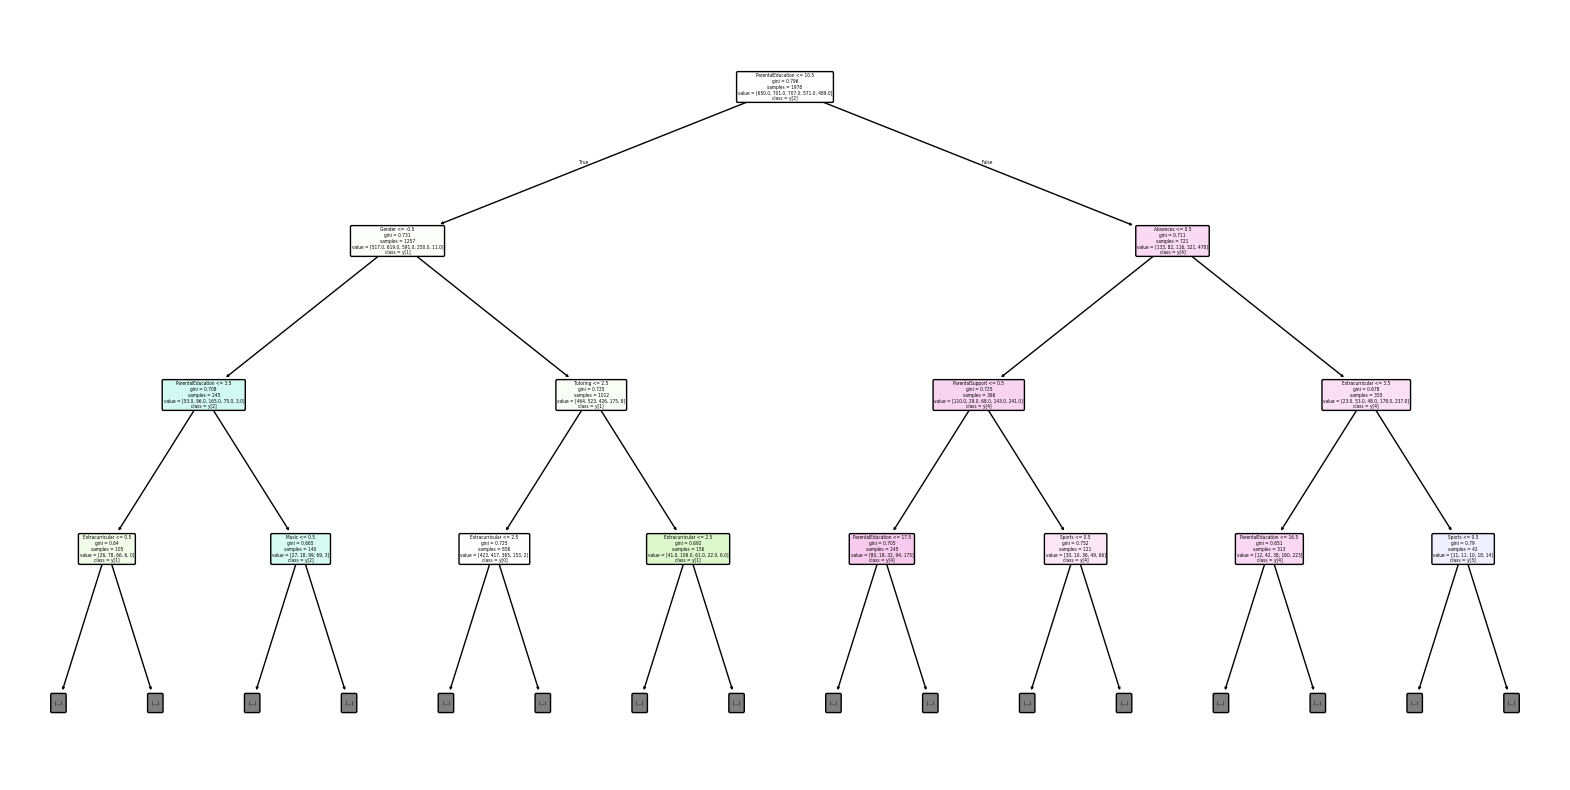

In [69]:
#Visualising one tree from the forest, visualising the entire forest would not be possible
# Pick one tree from the forest
plt.figure(figsize=(20,10))
plot_tree(rf_clf.estimators_[0], 
          feature_names=all_feature_names,
          class_names=True,  # or provide class names list
          filled=True, 
          rounded=True, 
          max_depth=3)  # limit depth for readability
plt.show()

In [73]:
# CPU usage percentage
print("CPU usage (%):", psutil.cpu_percent(interval=1))

# Memory usage
mem = psutil.virtual_memory()
print(f"Memory usage: {mem.percent}% used of {mem.total / (1024**3):.2f} GB")

start_time = time.time()
rf_clf.fit(X_train_processed, Y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time:.4f} seconds")

CPU usage (%): 13.5
Memory usage: 72.0% used of 8.00 GB
Training time: 0.2526 seconds


Classification report including precicion, recall, f1-score and support.

In [76]:

y_pred = rf_clf.predict(X_test_processed)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       630
           1       0.88      0.91      0.89       693
           2       0.86      0.90      0.88       703
           3       0.78      0.82      0.80       586
           4       0.81      0.88      0.84       506

    accuracy                           0.86      3118
   macro avg       0.86      0.86      0.86      3118
weighted avg       0.86      0.86      0.86      3118



### KNN

I run a for loop with different number of nearest neighbour values to not be bias towards the models above and understand if my KNN model is the best option after having analysed different values for K. 

In [79]:
#Declaring the variables
k_values = [3, 5, 7, 11, 15, 20] #k_values I am using 4 different values to see different accuracy values. Since I decided the best tree branch for
#my decision tree it would not be unbiased if I did not allow a similar treatment to this model.
val_accuracies = []
test_accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_processed, Y_train)
    
    val_preds = model.predict(X_val_processed)
    val_acc = accuracy_score(Y_val, val_preds)
    val_accuracies.append(val_acc)

    test_preds = model.predict(X_test_processed)
    test_acc = accuracy_score(Y_test, test_preds)
    test_accuracies.append(test_acc)

    print(f"\nK = {k}")
    print(f"Validation Accuracy: {val_acc:.2f}")
    print(f"Test Accuracy: {test_acc:.2f}")
    print("Test Classification Report:")
    print(classification_report(Y_test, test_preds))


K = 3
Validation Accuracy: 0.86
Test Accuracy: 0.85
Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       630
           1       0.87      0.90      0.88       693
           2       0.83      0.85      0.84       703
           3       0.77      0.77      0.77       586
           4       0.83      0.74      0.78       506

    accuracy                           0.85      3118
   macro avg       0.85      0.84      0.84      3118
weighted avg       0.85      0.85      0.85      3118


K = 5
Validation Accuracy: 0.79
Test Accuracy: 0.79
Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       630
           1       0.83      0.81      0.82       693
           2       0.72      0.80      0.75       703
           3       0.73      0.66      0.69       586
           4       0.83      0.68      0.74       506

    accuracy           

In order to be able to visualise the clusters of the 4 classes and interpret that I have to reduce the 10 features to 2 using PCA and then fit and train the model again with this change. For this I am interpreting the model using k=15 since that was the result with the best accuracy above. However, the interpretability is still not as good as with a decision tree. 

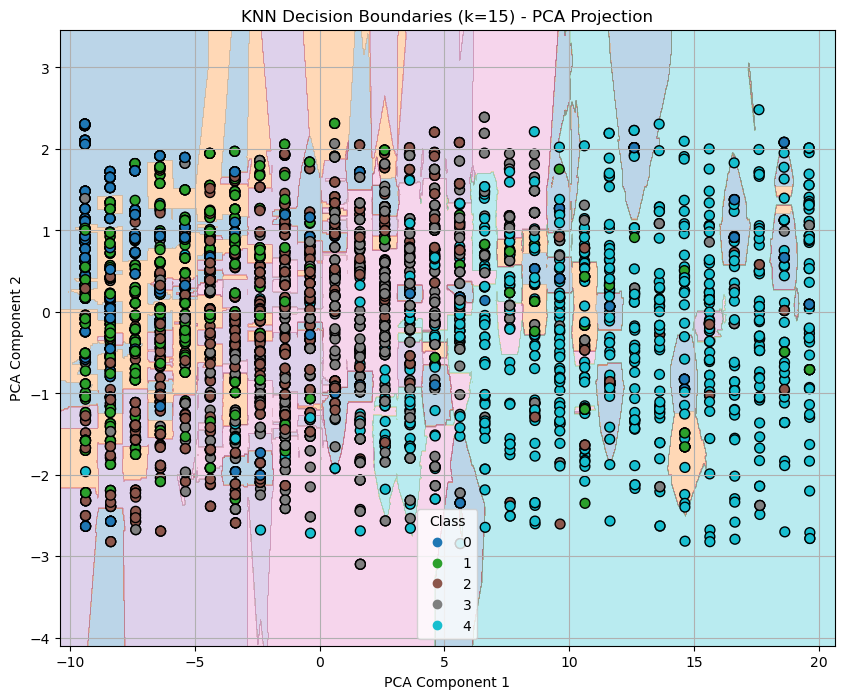

In [88]:
# Step 1: Reduce 10D data to 2D using PCA
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_processed)

# Step 2: Fit KNN on the 2D reduced data
k = 15  # or any other k you want to try
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_2d, Y_train)

# Step 3: Create meshgrid to draw decision boundaries
h = 0.02
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict over the grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Step 4: Plot the decision boundary and training points
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.tab10)

# Plot training points
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=Y_train,
                      cmap=plt.cm.tab10, edgecolor='k', s=50)

plt.title(f"KNN Decision Boundaries (k={k}) - PCA Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(*scatter.legend_elements(), title="Class")
plt.grid(True)
plt.show()


In [90]:
# CPU usage percentage
print("CPU usage (%):", psutil.cpu_percent(interval=1))

# Memory usage
mem = psutil.virtual_memory()
print(f"Memory usage: {mem.percent}% used of {mem.total / (1024**3):.2f} GB")

start_time = time.time()
model.fit(X_train_processed, Y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time:.4f} seconds")

CPU usage (%): 7.8
Memory usage: 72.1% used of 8.00 GB
Training time: 0.0074 seconds


## Model decision and hyperparameter tuning

Which model to use will be based on the score on all three sets as well as their computational time and interpretability. A balance between those three aspects is the deciding factor. 

1. Accuracy (cross validation accuracy): random forest and KNN perform the best, having precision and recall around at 80%. However, decision tree could improve significantly given that there has not been any hyperparameter tuning done yet it is fair to expect those results.
2. Computational time: the model with the least computational time is the KNN, but given its lack of interpretability due to the cluster plot and its low accuracy it is not a good enough factor to be the choosen model. Random forest has the highest computational time by 1 second above decision tree. 
3. Interpretation: In this area, decision trees are far better than the other two models. A random forest is hard to interpret because one can only interpret one tree from the forest at a time. KNN clusters don't show the features, nor a percentage similar to a Gini x, to help the user understand how the decision is made. However, random forests can still be interpreted, specially the feature importance. 

So, based on this the best model is a decision tree. In the end it comes down to interpretability. 
I am more comfortable sacrificing the accuracy that a random forest could provide after tuning if it means I can interpret my results better, especially given that this problem deals in an educational area where end-users will want to understand how decision were made. 


In [168]:
#Grid Search for hyperparameter tuning
# Define the model
dt = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [5, 10, 20],
    'max_features': ['sqrt', 'log2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=dt,
                           param_grid=param_grid,
                           scoring='accuracy',   # Or use another metric if preferred
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

# Fit Grid Search on training data
grid_search.fit(X_train_processed, Y_train)

# Best parameters and best score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Get best model to use later
best_dt = grid_search.best_estimator_

# Evaluate on test set
test_score = best_dt.score(X_test_processed, Y_test)
print("Test set accuracy with best model:", test_score)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_l

Even though my gridsearch defined that the parameters above are the best to use, I found that the ones below gave me the best results, especially for my test data. I added the criterion hyperparameter after trying out both gini and entropy.

In [271]:
clf = tree.DecisionTreeClassifier(max_depth = 15, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, criterion='entropy', random_state=2)
Y_train = Y_train.astype(int)
Y_val = Y_val.astype(int)
#Fit X_train and y_train 
clf.fit(X_train_processed, Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=5, random_state=2)

## Final accuracy

The final scores will be measured as follow: 

1. Accuracy on all three sets: to see how accurate my model is in predicting the different data sets.
2. Precision: how many predicted positives are correct
3. Recall: how many actual positives are detected
4. F1-score: harmonic mean of precision and recall

In [274]:
#Final score (accuracy) for each set using a decision tree. 
test_score = clf.score(X_test_processed, Y_test)
train_score = clf.score(X_train_processed, Y_train)
val_score = clf.score(X_val_processed, Y_val)

print('Testing set score', test_score)
print('Train set score', train_score)
print('Val set score', val_score)

Testing set score 0.6709429121231558
Train set score 0.940567853705486
Val set score 0.8652982681205901


In [276]:
y_pred = clf.predict(X_test_processed)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.57      0.69       630
           1       0.65      0.80      0.71       693
           2       0.64      0.70      0.67       703
           3       0.63      0.56      0.59       586
           4       0.63      0.70      0.66       506

    accuracy                           0.67      3118
   macro avg       0.69      0.67      0.67      3118
weighted avg       0.69      0.67      0.67      3118



The interpretation of these results are that my  model predicts the class 0 the best, but isn't as confident with the other classes.
Overall, this indicates that my model is performing well on all sets, with a decent balance between train and test scores and good precision/recall across classes. With more data (specially data that is not synthetic) I could achieve higher results. 

## Final plot

This final plot of my decision tree consists of the feature importance and the visualisation of the tree itself.

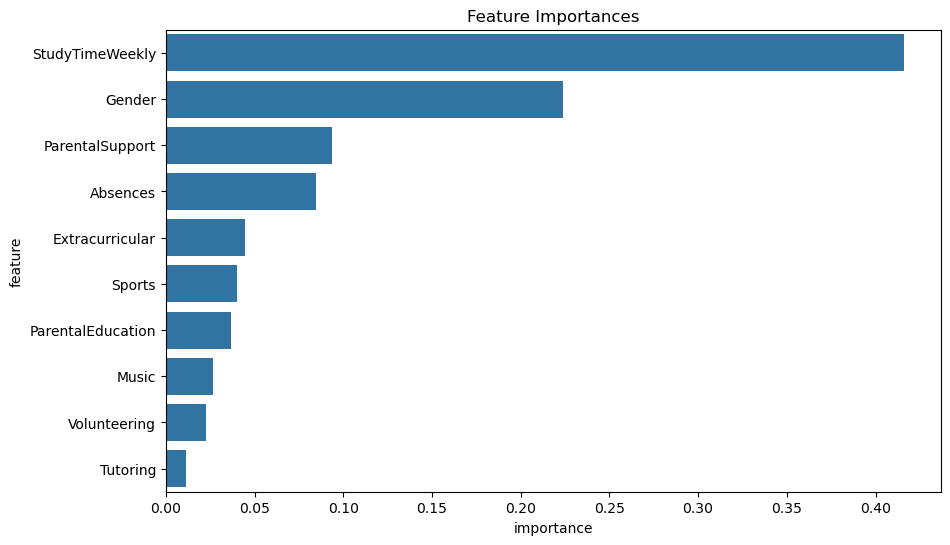

In [280]:
#feature importance
importances = clf.feature_importances_

X_train_scaled_visualise = pd.DataFrame(X_train_processed, columns=X_train.columns)
feature_names = X_train_scaled_visualise.columns

# Create a DataFrame for easy plotting
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title('Feature Importances')
plt.show()


This shows that the features that have the most impact when it comes to achieving good or bad grades. The common trend is that the features 'Tutoring' and 'Volunteering' have the least amount of impact. 

Weekly study time holds the most weight and is the key factor in deciding one's grade. Surprisingly, gender is the second most important factor. If this were to be removed, the other categories would hold more weight. 


A quick reminder on how to interpret the tree. 

Interpretation of the final nodes: the combination of features that led to that node show that students that have that specific combination of features are more likely to be in a certain class. 

Gini close to 0 = mostly or completely one class.

Gini close to 0.5 or more = mixed classes. So this combination of features gives random results and should not be focused on when deciding how to get the best grades.

Value = tells us how the training data was distributed at that node.

Class = X is what the tree will predict for any sample reaching this node.

In [106]:
#Plotting the tree, due to the amount of end nodes I decided to save it as a pdf to be able to zoom in and out of the nodes
dot_data = export_graphviz(
    clf,
    feature_names=all_feature_names,
    class_names=[str(cls) for cls in clf.classes_],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph.render("decision_tree", format="pdf")  # Saves as decision_tree.pdf
graph.view()

'decision_tree.pdf'